In [1]:
import os
import json
import pandas as pd
import numpy as np
from scipy.fft import fft
import matplotlib.pyplot as plt

In [2]:
# Pembacaan Parameter Dataset
filename = "parameter.json"
with open(filename, 'r') as f:
    params = json.load(f)

In [4]:
# Function to read dataset.csv
def read_csv(filepath, row=True):
    df = pd.read_csv(filepath, header=None)
    if row: # row data
        data = df.T.values.tolist()[0]
    else: # comma-separated column data
        data = df.values.tolist()[0]
    return data
def read_raw(filepath):
    raw = []
    with open(filepath) as f:
        # read all lines into list of string
        lines = f.readlines()
        for line in lines:
            # remove leading and trailing white spaces and split by comma delimiter
            raw += line.strip().split(',')
    raw = [complex(s.replace('i', 'j')) for s in raw]
    return raw

In [5]:
dataset_folder = 'E:\Read-Dataset-Publik-Radar-FMCW-\Children Dataset'
radar_raw_folder = os.path.join(dataset_folder, "FMCW Radar\Rawdata")
radar_vital_folder = os.path.join(dataset_folder, "FMCW Radar\Heart Rate & Breathing Rate")
ref_raw_folder = os.path.join(dataset_folder, "Nihon Kohden\Heartbeat & Breathing Waveform")
ref_vital_folder = os.path.join(dataset_folder, "Nihon Kohden\Heart Rate & Breathing Rate")
subject_stats_folder = os.path.join(dataset_folder, "Participant\Human Data")
subject_photo_folder = os.path.join(dataset_folder, "Participant\Picture")

# Subject
subject_id = 1
radar_raw_path = os.path.join(radar_raw_folder, f"Rawdata_{subject_id}.csv")
raw_data = read_raw(radar_raw_path)## Pemanggilan Dataset Dari Folder 
# Merubah data list ke Array 
raw_data = np.asarray(raw_data, dtype=complex)
n_samples = raw_data.shape[0]//params['n_rx']
# print(raw_data.shape[0])
raw_radar = raw_data.reshape(params['n_rx'],n_samples, order='C')
raw_new = raw_radar.reshape((params['n_rx'],params['n_adc']*params['n_chirp'],-1), order='F')
#read heart rate (HR) and breath rate (BR) reading from reference device
ref_hr_path = os.path.join(ref_vital_folder, f"Ref_Heart_{subject_id}.csv")
ref_br_path = os.path.join(ref_vital_folder, f"Ref_Breath_{subject_id}.csv")
# Radar Paper
# read heart rate (HR) and breath rate (BR) estimation from radar
hr_radar_path = os.path.join(radar_vital_folder, f"Heart_{subject_id}.csv")
br_radar_path = os.path.join(radar_vital_folder, f"Breath_{subject_id}.csv")
#df_radar = pd.read_csv(hr_radar_path, header=None)
hr_radar = read_csv(hr_radar_path, row=True)
br_radar = read_csv(br_radar_path, row=True)
#df_hr = pd.read_csv(ref_hr_path, header=None)
hr = read_csv(ref_hr_path, row=False)
br = read_csv(ref_br_path, row=False)
# Waveform 
radar_br_wave_path = os.path.join(ref_raw_folder, f"Ref_Breath_Wave_{subject_id}.csv")
radar_hr_wave_path = os.path.join(ref_raw_folder, f"Ref_Heart_Wave_{subject_id}.csv")
br_wave =np.array(read_csv(radar_br_wave_path))
hr_wave =np.array(read_csv(radar_hr_wave_path,row=True))

In [6]:
import csv
for i in range(1, 51):
    radar_br_wave_path = os.path.join(ref_raw_folder, f"Ref_Breath_Wave_{i}.csv")
    radar_hr_wave_path = os.path.join(ref_raw_folder, f"Ref_Heart_Wave_{i}.csv")
    br_wave =np.array(read_csv(radar_br_wave_path)).reshape(1,-1)
    hr_wave =np.array(read_csv(radar_hr_wave_path,row=True)).reshape(1,-1)
    for j in range(4):
        with open('br_wave.csv', 'a') as f: 
            # Create a CSV writer object that will write to the file 'f'
            csv_writer = csv.writer(f)
        
            # Write all of the rows of data to the CSV file
            csv_writer.writerows(br_wave)
        with open('hr_wave.csv', 'a') as f: 
            # Create a CSV writer object that will write to the file 'f'
            csv_writer = csv.writer(f)
        
            # Write all of the rows of data to the CSV file
            csv_writer.writerows(hr_wave)

In [7]:
br_target = []
hr_target = []

with open('br_wave.csv', mode ='r')as file:
  csvFile = csv.reader(file)
  for lines in csvFile:
        br_target.append(lines)
        
with open('hr_wave.csv', mode ='r')as file:
  csvFile = csv.reader(file)
  for lines in csvFile:
        hr_target.append(lines)

In [8]:
br_target_array = []
hr_target_array = []
for i in range(0, 400, 2):
    br_target_array.append(br_target[i])
    hr_target_array.append(hr_target[i])
    
br_target_array = np.array(br_target_array).astype(np.int64)
hr_target_array = np.array(hr_target_array).astype(np.int64)

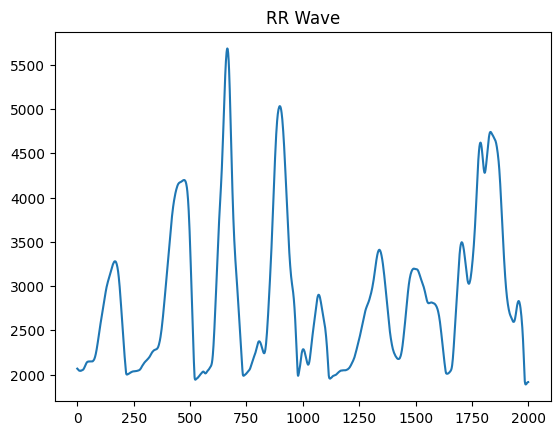

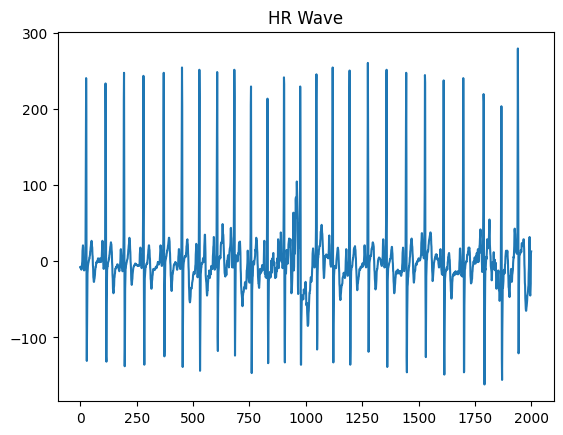

In [9]:
plt.figure(1)
plt.title("RR Wave")
plt.plot(br_target_array[0][:2000],label="RR Wave")
plt.figure(2)
plt.title("HR Wave")
plt.plot(hr_target_array[0][:2000],label="HR Wave")

In [13]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()

# Faktor downsampling
downsampling_factor = 37500 // 6000  # 37500 / 6000 = 6.25

hr_norm = pt.fit_transform(hr_target_array[0].reshape(-1, 1))
# Downsampling dengan mengambil setiap sampel ke-n
hr_downsampled_signal = hr_norm[::downsampling_factor]

# Pastikan ukuran sinyal hasil downsampling adalah (6000, 1)
hr_downsampled_signal = hr_downsampled_signal[:6000]

print("Ukuran sinyal asli:", hr_target_array[0].shape)
print("Ukuran sinyal setelah downsampling:", hr_downsampled_signal.shape)

Ukuran sinyal asli: (37500,)
Ukuran sinyal setelah downsampling: (6000, 1)


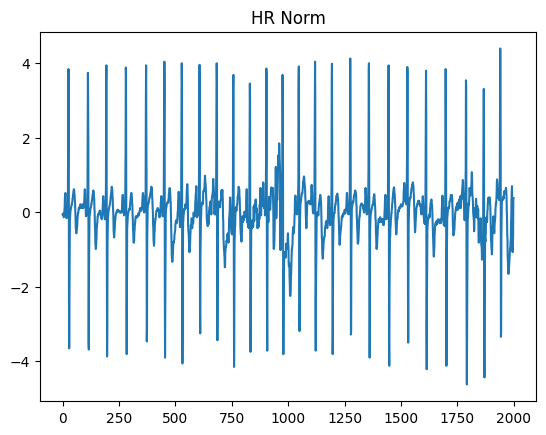

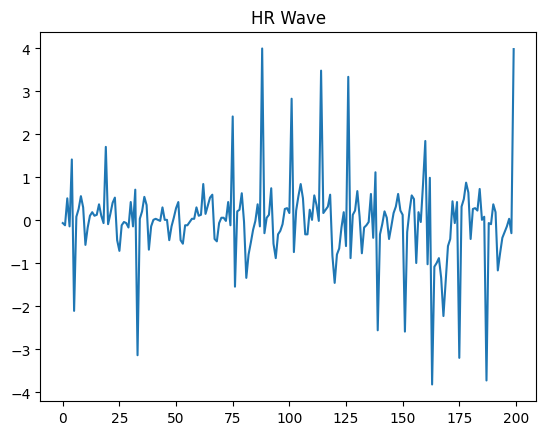

In [14]:
plt.figure(1)
plt.title("HR Norm")
plt.plot(hr_norm[:2000],label="HR Wave")
plt.figure(2)
plt.title("HR Wave")
plt.plot(hr_downsampled_signal[:200],label="HR Wave")

In [15]:
# Contoh sinyal ECG dengan ukuran (37500, 1)
pt = PowerTransformer()
# Faktor downsampling
downsampling_factor = 37500 // 6000  # 37500 / 6000 = 6.25

br_norm = pt.fit_transform(br_target_array[0].reshape(-1, 1))

# Downsampling dengan mengambil setiap sampel ke-n
br_downsampled_signal = br_norm[::downsampling_factor]

# Pastikan ukuran sinyal hasil downsampling adalah (6000, 1)
br_downsampled_signal = br_downsampled_signal[:6000]

print("Ukuran sinyal asli:", br_target_array[0].shape)
print("Ukuran sinyal setelah downsampling:", br_downsampled_signal.shape)

Ukuran sinyal asli: (37500,)
Ukuran sinyal setelah downsampling: (6000, 1)


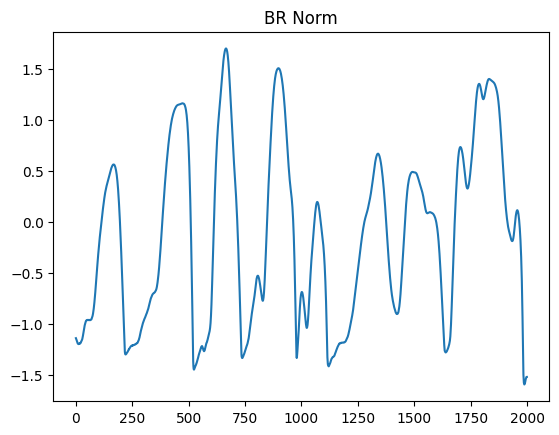

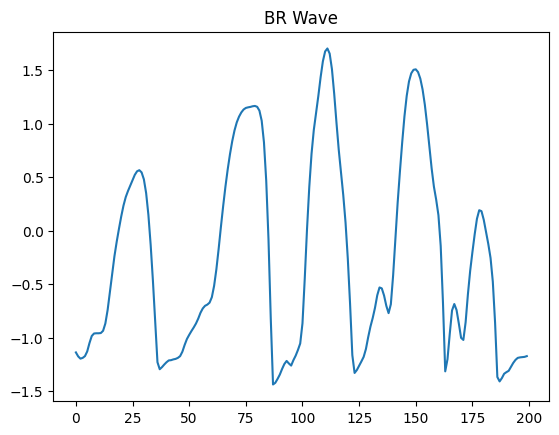

In [16]:
plt.figure(1)
plt.title("BR Norm")
plt.plot(br_norm[:2000],label="HR Wave")
plt.figure(2)
plt.title("BR Wave")
plt.plot(br_downsampled_signal[:200],label="HR Wave")

In [17]:
from f_fft_sinyal import fft_sinyal
def calculate_hr_rr(data_rr,data_hr):
    data_rr = np.array(data_rr)
    data_hr = np.array(data_hr)
    freq_rr, fft_rr = fft_sinyal(data_rr)
    freq_hr, fft_hr = fft_sinyal(data_hr)
    peak1 = np.argmax(fft_rr[:20])
    peak2 = np.argmax(fft_hr[:80])
    bpm_rr = freq_rr[peak1]*60
    bpm_hr = freq_hr[peak2]*60
    return bpm_rr, bpm_hr

In [18]:
start = 0
counter = 0
An1_RR = br_downsampled_signal
An1_HR = hr_downsampled_signal


HR_an1 =[]
RR_an1 =[]
while counter < 280:  # Changed the loop condition to run for 280 iterations
        if start + 400 < len(An1_RR):
            An1_segment_RR = An1_RR[start:start + 400]
            # HR
            An1_segment_HR = An1_HR[start:start + 400]

        else:
            An1_segment_RR = An1_RR[start:]
            #HR 
            An1_segment_HR = An1_HR[start:]
        # Select The IMF 
        Rr1,Hr1 = calculate_hr_rr(An1_segment_RR,An1_segment_HR)

        # rr1,hr1 = calculate_hr_rr(u_rr1, u_hr1)
        # rr2,hr2 = calculate_hr_rr(u_rr2, u_hr2)
        # rr3,hr3 = calculate_hr_rr(u_rr3, u_hr3)
        # rr4,hr4 = calculate_hr_rr(u_rr4, u_hr4) 
       
    
        # HR_an1.append(hr1)
        # HR_an2.append(hr2)
        # HR_an3.append(hr3)
        # HR_an4.append(hr4)
        # RR_an1.append(rr1)
        # RR_an2.append(rr2)
        # RR_an3.append(rr3)
        # RR_an4.append(rr4)
        HR_an1.append(Hr1)
        RR_an1.append(Rr1)

        counter += 1
        start = start + 20



In [19]:
# Kalman 
import numpy as np 

def kalman_filter(z_ppg1):

    Q=3**2
    R=100**2
#     Q=4**2;                    
#     R=10**2;

    count=0
    countmax=5
    imax=3

    xposteriori=z_ppg1[0]
    res = np.zeros(len(z_ppg1))
    res[0]=z_ppg1[0]
    Pposteriori=0
    hasil =[]

    for i in range (1, len(z_ppg1)):

        xpriori=xposteriori
        Ppriori=Pposteriori+Q

        S=Ppriori+R
        gain=Ppriori/S

        inn1=z_ppg1[i]-xpriori

        if (((count==countmax or i<imax) and ~np.isnan(inn1))):
            inn=inn1
            xposteriori=xpriori+gain*inn
            Pposteriori=(1-gain)*Ppriori
            if(count==countmax ):
                xposteriori=0.5*(z_ppg1[i]+xpriori)
            count=0

        else:
            count=count+1
            xposteriori=xpriori
            Pposteriori=Ppriori

        res[i]=xposteriori
        hasil.append(xposteriori)

    return hasil

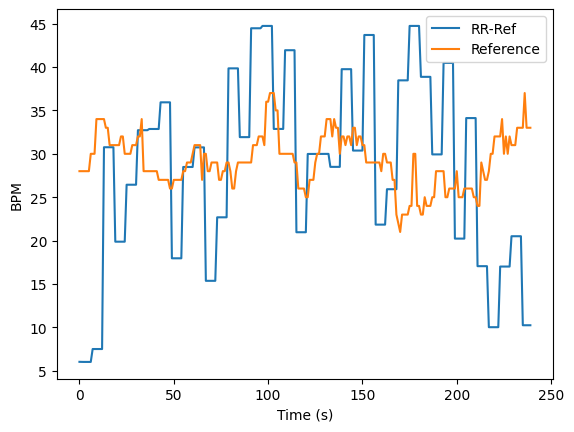

In [26]:
# RR 
RR_an1 = np.array(RR_an1)
Kalman_rr = kalman_filter(RR_an1)
RR_ref = br[21:261]
plt.plot(Kalman_rr[:240],label ="RR-Ref")
plt.plot(RR_ref, label="Reference")
plt.xlabel("Time (s)")
plt.ylabel("BPM")
plt.legend()

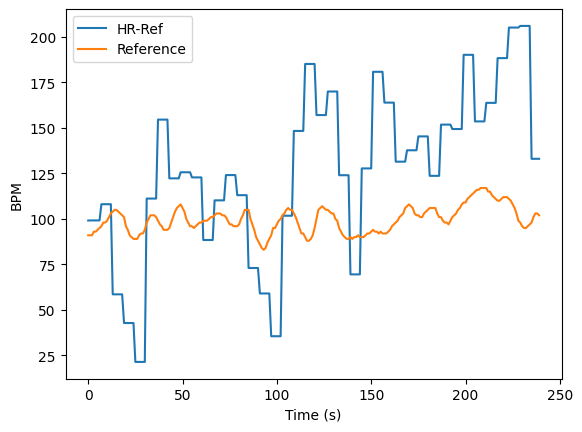

In [24]:
HR_an1 = np.array(HR_an1)
Kalman_Hr = kalman_filter(HR_an1)
HR_ref = hr[21:261]
plt.plot(Kalman_Hr[:240],label ="HR-Ref")
plt.plot(HR_ref, label="Reference")
plt.xlabel("Time (s)")
plt.ylabel("BPM")
plt.legend()